In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
from matplotlib import dates as mdates
import constants as cnst

# Load cycles from nxcals data

In [2]:
accelerator = 'CPS'
year = '2023' # 2022 or 2023
path = '../../../07_special_presentations/02_JAPW_talk_2023/002_intensity_data/%s/%s/'%(year,accelerator)
files = os.listdir(path)
files = [file for file in files if file.endswith('.pkl')]
files.sort()
#files
#len(files)

i0 = 60
number_of_days = 215 # ~31 weeks
files = files[i0:(i0+215)]
print('Will load data from %s until %s.'%(files[0].split('.')[0], files[-1].split('.')[0]))
print('This corresponds to %s days or approximately %1.1f million BPs.'%(number_of_days, 1e-6*number_of_days*24*60*60/cnst.BASIC_PERIOD))

Will load data from 2023-04-02 until 2023-11-02.
This corresponds to 215 days or approximately 15.5 million BPs.


In [3]:
# Count cycles based on destination
cycle2destination = {
    'AD': ['TT2_FTA'],
    'EAST+nTOF': ['EAST_N', 'EAST_T8', 'EAST_T9', 'NTOF'],
    'AWAKE': ['AWAKE'],
    'SFTPRO': ['FTARGET'],
    'HiRadMat': ['HIRADMAT'],
    'LHC filling + setup': ['LHC'],
    'MD+Setup': ['EAST_DMP', 'PS_DUMP', 'SPS_DUMP', 'TT2_D3', 'NaN'],
    'Zero': [None]
}
cycle_counts = {}
cycle_time = {}
for key in cycle2destination.keys():
    cycle_counts[key] = 0
    cycle_time[key] = 0
destinations = []
for file in files:
    print(file)
    df = pd.read_pickle(path + file)
    
    # to fix hashability error
    string_columns = df.select_dtypes(include='string').columns
    for col in string_columns:
        df[col] = df[col].apply(lambda x: str(x) if not pd.isna(x) else 'NaN').astype('string')
    df.reset_index(inplace=True)
    
    # keep only relevant columns
    df = df[['nxcals_timestamp', 'CPS.LSA:CYCLE', 'CPS.TGM:USER', 'CPS.TGM:DEST', 'CPS.TGM:DEST2']]
    
    # Calculate cycle length ("by hand")
    df['%s.TGM:CYCLE_LENGTH'%accelerator] = list(df['nxcals_timestamp'].diff())[1::]+[np.nan]

    # destinations
    destinations += df['CPS.TGM:DEST'].unique().tolist()

    # count cycles based on destination
    for key in cycle2destination.keys():
        if key == 'Zero': # count zeros separately
            cycle_counts[key] += len(df[df['CPS.TGM:USER']=='ZERO'])
            cycle_time[key] += df['%s.TGM:CYCLE_LENGTH'%accelerator][df['CPS.TGM:USER']=='ZERO'].sum().total_seconds()
        else:
            cycle_counts[key] += len(df[df['CPS.TGM:DEST'].isin(cycle2destination[key])])
            cycle_time[key] += df['%s.TGM:CYCLE_LENGTH'%accelerator][df['CPS.TGM:DEST'].isin(cycle2destination[key])].sum().total_seconds()

# To separate the zeros from the rest
cycle_counts['MD+Setup'] = cycle_counts['MD+Setup'] - cycle_counts['Zero']
cycle_time['MD+Setup'] = cycle_time['MD+Setup'] - cycle_time['Zero']

2023-04-02.pkl
2023-04-03.pkl
2023-04-04.pkl
2023-04-05.pkl
2023-04-06.pkl
2023-04-07.pkl
2023-04-08.pkl
2023-04-09.pkl
2023-04-10.pkl
2023-04-11.pkl
2023-04-12.pkl
2023-04-13.pkl
2023-04-14.pkl
2023-04-15.pkl
2023-04-16.pkl
2023-04-17.pkl
2023-04-18.pkl
2023-04-19.pkl
2023-04-20.pkl
2023-04-21.pkl
2023-04-22.pkl
2023-04-23.pkl
2023-04-24.pkl
2023-04-25.pkl
2023-04-26.pkl
2023-04-27.pkl
2023-04-28.pkl
2023-04-29.pkl
2023-04-30.pkl
2023-05-01.pkl
2023-05-02.pkl
2023-05-03.pkl
2023-05-04.pkl
2023-05-05.pkl
2023-05-06.pkl
2023-05-07.pkl
2023-05-08.pkl
2023-05-09.pkl
2023-05-10.pkl
2023-05-11.pkl
2023-05-12.pkl
2023-05-13.pkl
2023-05-14.pkl
2023-05-15.pkl
2023-05-16.pkl
2023-05-17.pkl
2023-05-18.pkl
2023-05-19.pkl
2023-05-20.pkl
2023-05-21.pkl
2023-05-22.pkl
2023-05-23.pkl
2023-05-24.pkl
2023-05-25.pkl
2023-05-26.pkl
2023-05-27.pkl
2023-05-28.pkl
2023-05-29.pkl
2023-05-30.pkl
2023-05-31.pkl
2023-06-01.pkl
2023-06-02.pkl
2023-06-03.pkl
2023-06-04.pkl
2023-06-05.pkl
2023-06-06.pkl
2023-06-07

In [4]:
# The different destinations
#df
print(np.unique(destinations))

['AWAKE' 'EAST_DMP' 'EAST_N' 'EAST_T8' 'EAST_T9' 'FTARGET' 'HIRADMAT'
 'LHC' 'NTOF' 'NaN' 'PS_DUMP' 'SPS_DUMP' 'TT2_D3' 'TT2_FTA']


In [6]:
print('Number of cycles played for each user:')
print(cycle_counts)
print('Number of time spent on each user:')
print(cycle_time)
print('Number of BPs for each cycle:')
cycle_bps = {key: cycle_time[key]/cnst.BASIC_PERIOD for key in cycle_time.keys()}
print(cycle_bps)
print('Total BPs played: %1.1f million'%(1e-6*sum(list(cycle_bps.values()))))

Number of cycles played for each user:
{'AD': 102815, 'EAST+nTOF': 4832452, 'AWAKE': 69684, 'SFTPRO': 1466503, 'HiRadMat': 66674, 'LHC filling + setup': 363515, 'MD+Setup': 770318, 'Zero': 3880255}
Number of time spent on each user:
{'AD': 246753.59999999998, 'EAST+nTOF': 8781384.000000004, 'AWAKE': 167241.60000000006, 'SFTPRO': 2032843.2, 'HiRadMat': 221752.80000000005, 'LHC filling + setup': 961477.2, 'MD+Setup': 1502860.8000000035, 'Zero': 4661046.0}
Number of BPs for each cycle:
{'AD': 205628.0, 'EAST+nTOF': 7317820.000000004, 'AWAKE': 139368.00000000006, 'SFTPRO': 1694036.0, 'HiRadMat': 184794.00000000006, 'LHC filling + setup': 801231.0, 'MD+Setup': 1252384.000000003, 'Zero': 3884205.0}
Total BPs played: 15.5 million


# Plots

In [12]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

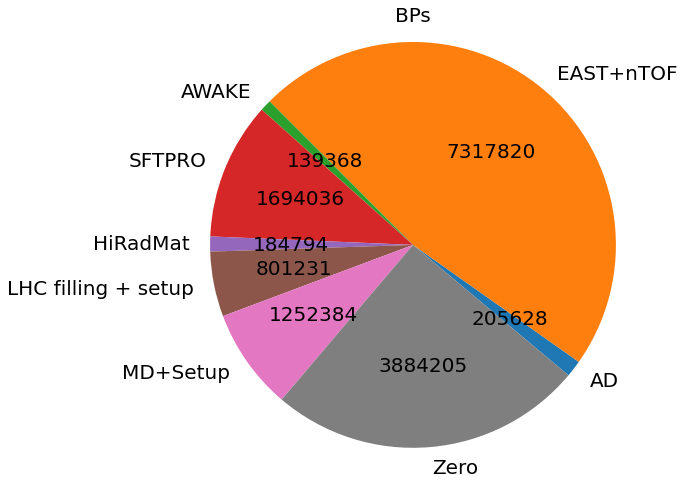

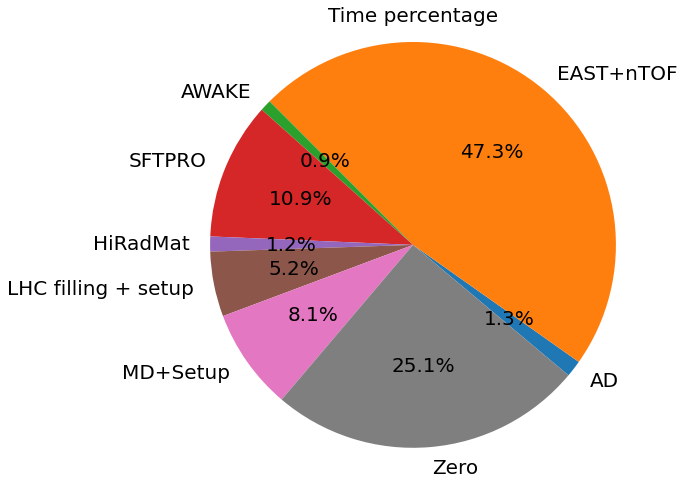

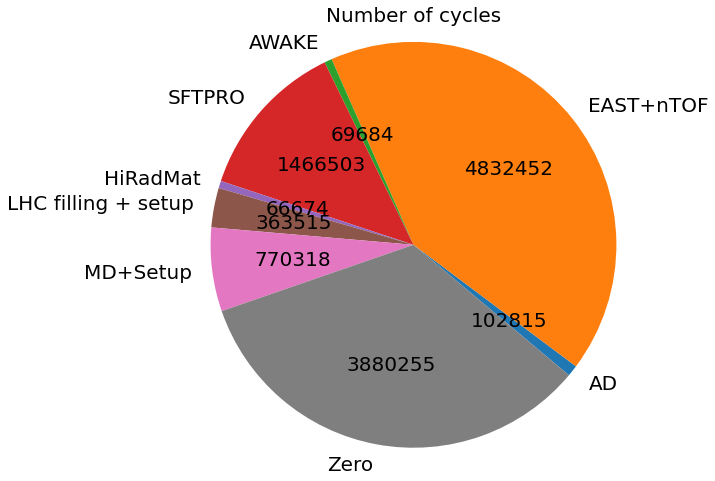

In [16]:
labels = list(cycle_time.keys())
for title, sizes in zip(['BPs', 'Time percentage', 'Number of cycles'],
                        [list(cycle_bps.values()), 
                         list(cycle_time.values()),
                         list(cycle_counts.values())]
                         ):

    if 'percentage' in title:
        autopct = '%1.1f%%'
    else:
        autopct = autopct_format(sizes)

    fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')
    fontsize=20
    ax.set_title(title, fontsize=fontsize)
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct=autopct,
        startangle=-40,
        textprops=dict(color="black", size=fontsize)  # Adjust the text properties
    )
    # Adjust the labels to be inside the pie chart
    for text, autotext in zip(texts, autotexts):
        text.set(size=fontsize)
        autotext.set(size=fontsize)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [17]:
print('Total BPs played: %1.1f million'%(1e-6*sum(list(cycle_time.values()))/cnst.BASIC_PERIOD))

Total BPs played: 15.5 million
